In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, Kernel, Hyperparameter
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import GPy

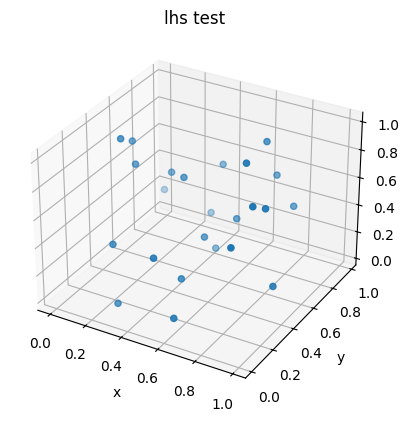

X, Y, Z values:
Point 1: x=0.7070, y=0.8719, z=0.6014
Point 2: x=0.0658, y=0.5854, z=0.8021
Point 3: x=0.0014, y=0.9760, z=0.1675
Point 4: x=0.9940, y=0.3212, z=0.2877
Point 5: x=0.8319, y=0.8158, z=0.4570
Point 6: x=0.8664, y=0.1510, z=0.6314
Point 7: x=0.5199, y=0.5014, z=0.3274
Point 8: x=0.6155, y=0.6435, z=0.4008
Point 9: x=0.3833, y=0.9120, z=0.5383
Point 10: x=0.9271, y=0.3589, z=0.7823
Point 11: x=0.8996, y=0.2885, z=0.8334
Point 12: x=0.4528, y=0.7244, z=0.0622
Point 13: x=0.1415, y=0.4935, z=0.7205
Point 14: x=0.5478, y=0.2426, z=0.2175
Point 15: x=0.3739, y=0.5557, z=0.6689
Point 16: x=0.2751, y=0.1125, z=0.0211
Point 17: x=0.2945, y=0.9474, z=0.1188
Point 18: x=0.4964, y=0.0827, z=0.4604
Point 19: x=0.7832, y=0.4326, z=0.9956
Point 20: x=0.6452, y=0.0147, z=0.1411
Point 21: x=0.1990, y=0.1959, z=0.3623
Point 22: x=0.2196, y=0.6940, z=0.5612
Point 23: x=0.7097, y=0.7594, z=0.9137
Point 24: x=0.1143, y=0.4104, z=0.9438


In [2]:
# Generate optimized LHS
lhs = qmc.LatinHypercube(d=3)
samples = lhs.random(n=24)

#plt.scatter(samples[:, 0], samples[:, 1]) # for 2d 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('lhs test')
plt.show()

# Print x, y, z values in a readable format
print("X, Y, Z values:")
for i, (x, y, z) in enumerate(samples):
    print(f"Point {i+1}: x={x:.4f}, y={y:.4f}, z={z:.4f}")

In [8]:
class CategoryOverlapKernel(Kernel):
    def __init__(self, variance = 1.0):
        self.variance = variance # kernel variance
        #define variance as a hyperparameter (log-scaled for positive values)
        self.hyperparameter_variance = Hyperparameter("variance", "log", 1e-2, 10.0)
    def __call__(self, X, Y = None, eval_gradient = False):
        if Y is None:
            Y = X
        
        # Compute categorical overlap (1 if same, 0 if different)
        diff = X[:, None] != Y[None, :] # Boolean matrix (True if different)
        k_cat = self.variance * (1-np.mean(diff, axis=-1)) # normalizes overlap

        if eval_gradient:
            # Gradient w.r.t. variance
            grad = np.ones_like(k_cat)[..., np.newaxis] # Shape: (n_samples, n_samples, 1)
            return k_cat, grad
        return k_cat
    
    def diag(self, X):
        return np.full(X.shape[0], self.variance) # self-similarity
    
    def is_stationary(self):
        return False
    
class CategoryOverlapKernelGPy(GPy.kern.Kern):
    """GPy implementation of a categorical overlap kernel."""

    def __init__(self, input_dim, variance=1.0, active_dims=None, name='catoverlap'):
        super().__init__(input_dim, active_dims=active_dims, name=name)
        self.variance = GPy.core.parameterization.Param('variance', variance)
        self.link_parameter(self.variance)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X

        diff = X[:, None] - X2[None, :]
        diff[np.where(np.abs(diff))] = 1  # Mark different categories
        k_cat = self.variance * (1 - np.mean(diff, axis=-1))  # Normalize overlap
        return k_cat



In [9]:
X_test = np.array([[0], [1], [2], [1], [0]]) #each row is a category

# Create kernel and compute the kernel matrix
gpy_kernel = CategoryOverlapKernelGPy(input_dim=1, variance=1.0)
K_gpy = gpy_kernel.K(X_test)
print("GPy Kernel Matrix:\n", K_gpy)

#create kernel and compute the kernel matrix
skl_kernel = CustomKernel(variance=1.0)
K_skl = skl_kernel(X_test)
print("SKL Kernel Matrix:\n", K_skl)

GPy Kernel Matrix:
 [[1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]


NameError: name 'CustomKernel' is not defined

Below is a working model of the categorical/ continuous combined in a kernel

In [12]:
import numpy as np
from sklearn.gaussian_process.kernels import Kernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Hyperparameter
from sklearn.preprocessing import LabelEncoder  # To handle categorical encoding

class CategoryOverlapKernel(Kernel):
    def __init__(self, overlap_variance=1.0):
        self.overlap_variance = overlap_variance  # Kernel variance
        # Define variance as a hyperparameter (log-scaled for positive values)
        self.hyperparameter_variance = Hyperparameter("overlap_variance", "log", 1e-2, 10.0)
    
    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        
        # Compute categorical overlap (1 if same, 0 if different)
        diff = X[:, None] != Y[None, :]  # Boolean matrix (True if different)
        k_cat = self.overlap_variance * (1 - np.mean(diff, axis=-1))  # Normalizes overlap

        if eval_gradient:
            # Gradient w.r.t. variance
            grad = np.ones_like(k_cat)[..., np.newaxis]  # Shape: (n_samples, n_samples, 1)
            return k_cat, grad
        return k_cat
    
    def diag(self, X):
        return np.full(X.shape[0], self.overlap_variance)  # Self-similarity (diagonal) is the variance
    
    def is_stationary(self):
        return False

class CustomKernel(Kernel):
    """Custom Kernel that combines a Matern Kernel for continuous data and Category Overlap Kernel for categorical data."""
    
    def __init__(self, length_scale=1.0, lambda_param=0.5, variance=1.0):  # This variance value feeds into CategoryOverlapKernel (check if this assumption is okay)
        self.length_scale = length_scale
        self.lambda_param = lambda_param  # Add lambda_param to the constructor
        self.variance = variance  # Store 'variance' directly in CustomKernel
        self.category_overlap_kernel = CategoryOverlapKernel(overlap_variance=variance)  # Pass 'variance' to CategoryOverlapKernel
    
    def __call__(self, X, Y=None, eval_gradient=False):
        """Compute the kernel matrix."""
        # Compute Matern Kernel for continuous data (assuming X and Y are continuous for this part)
        matern_kernel = Matern(length_scale=self.length_scale, nu=2.5)  # Matern kernel (nu=2.5 as suggested)
        matern_matrix = matern_kernel(X, Y)

        # Compute Category Overlap Kernel for categorical data
        category_overlap_matrix = self.category_overlap_kernel(X, Y)  # Correct access to the category_overlap_kernel

        # Combine the Matern and Category Overlap Kernels using the formula
        K = (1 - self.lambda_param) * (matern_matrix + category_overlap_matrix) + (self.lambda_param * matern_matrix * category_overlap_matrix)  # Ru's multiplication + summation

        if eval_gradient:
            # Compute gradient w.r.t. hyperparameters for both kernels
            matern_grad = matern_kernel(X, Y, eval_gradient=True)[1]  # Gradient of Matern Kernel
            overlap_grad = self.category_overlap_kernel(X, Y, eval_gradient=True)[1]  # Gradient of overlap kernel

            # Stack gradients together
            return K, np.dstack((matern_grad, overlap_grad))
        
        return K
    
    def diag(self, X):
        """Diagonal elements (self-similarity should be 1)."""
        return np.ones(X.shape[0])

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

# Example continuous and categorical data
X_continuous = np.array([[1.0], [2.0], [3.0], [4.0]])  # Continuous data
X_categorical = np.array([['cat'], ['dog'], ['cat'], ['dog']])  # Categorical data

# Convert categorical data to numeric values using LabelEncoder
encoder = LabelEncoder()
X_categorical_encoded = encoder.fit_transform(X_categorical.ravel()).reshape(-1, 1)  # Flatten for encoding

# Combine the continuous and categorical data into a single array
X_train = np.hstack([X_continuous, X_categorical_encoded])  # Now all data is numeric

# Instantiate the custom kernel
kernel = CustomKernel(length_scale=1.0, lambda_param=0.5, variance=1.0)  # Pass 'lambda_param' here

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel)

# Fit the model with some target values (for demonstration purposes)
gp.fit(X_train, np.array([2.0, 0.42, 42.0, 1.111111]))

# Make predictions
predictions = gp.predict(X_train)

print("Predictions:", predictions)


Predictions: [ 2.        0.42     42.        1.111111]


In [13]:
K = kernel(X_train)
print("Kernel Matrix:/n:", K)
print("kernel diagonal:/n", np.diag(K))

eigenvalues = np.linalg.eigvals(K)
print("eigen values:", eigenvalues)
print("are all eigenvals >= 0?", np.all(eigenvalues >= 0))

Kernel Matrix:/n: [[1.5        0.15864168 0.35399516 0.0105052 ]
 [0.15864168 1.5        0.15864168 0.35399516]
 [0.35399516 0.15864168 1.5        0.15864168]
 [0.0105052  0.35399516 0.15864168 1.5       ]]
kernel diagonal:/n [1.5 1.5 1.5 1.5]
eigen values: [2.10253352 1.6243502  1.06661336 1.20650292]
are all eigenvals >= 0? True


In [12]:
print(X_train)

[[1. 0.]
 [2. 1.]
 [3. 0.]
 [4. 1.]]


Let's try a GPyTorch implementation as this may likely be the ideal package for end applications and extending the project beyond its current scope

In [10]:
import torch
import gpytorch

class CategoryOverlapKernel(gpytorch.kernels.Kernel):
    """Custom kernel for cateogrical varaibles using category overlap similarity."""
    
    def __init__(self, **kwargs):
        super().__init__(has_lengthsacle = False, **kwargs)
    
    def forward(self, x1, x2, diag = False, **params):
        if diag:
            return torch.ones(x1.shape[0], dtype=x1.dtype, device=x1.device)
        
        #check if categorical values are teh same (Kronecker delta function)
        overlap = x1[:, None] == x2[None, :].float()
        return overlap
    
    
class CombinedKernel(gpytorch.kernels.Kernel):
    """Combined Matern kernel and Category Overlap Kernel"""

    def __init__(self, matern_nu=2.5, **kwargs):
        super().__init__(**kwargs)
        self.matern_kernel = gpytorch.kernels.MaternKernel(nu=matern_nu)
        self.category_kernel = CategoryOverlapKernel()

    def forward(self, x1, x2, diag = False, **params):
        #split cont and cat features
        x1_cont, x1_cat = x1[..., :-1], x1[..., -1]
        x2_cont, x2_cat = x2[..., :-1], x2[..., -1]

        # computer kernel values
        matern_val = self.matern_kernel(x1_cont, x2_cont, diag=diag, **params)
        category_val = self.category_kernel(x1_cat, x2_cat, diag=diag, **params)

        #combine kernels
        return matern_val * category_val
    
class CustomGPModel(gpytorch.models.ExactGP):
    def __init__ (self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = CombinedKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    